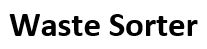

Importing Modules

In [ ]:
import os
import numpy as np
import pandas as pd 

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
import matplotlib
import random

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization

from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler


Defining Variables

In [ ]:
epochs = 40

Im_W = 256
Im_H = 192
Im_size = (Im_W, Im_H)
Im_channels = 3

batch_size = 32

d_rate = 0.3



Integrating Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing Images

In [ ]:
dir = '/content/drive/MyDrive/Images/'
file_names = os.listdir(dir)
print(len(file_names))

1200


Creating Categories

In [ ]:
df = pd.DataFrame({
    'Filename': [],
    'Waste Type': []
})

for filename in file_names:
    Waste_Type = filename[0:3]
    
    
    if Waste_Type == 'gla':
        categories='glass'
    elif Waste_Type == 'met':
        categories='metal'
    elif Waste_Type == 'pap':
        categories='paper'
    elif Waste_Type == 'pla':
        categories='plastic'
   
    df=df.append({'Filename':dir + filename, 'Waste Type': categories},ignore_index=True)


Category Data Frame Description

In [ ]:
df[df["Waste Type"]== "glass"].shape

(300, 2)

In [ ]:
df.head()

,Filename,Waste Type
0,/content/drive/MyDrive/Images/metal235.jpg,metal
1,/content/drive/MyDrive/Images/metal220.jpg,metal
2,/content/drive/MyDrive/Images/glass287.jpg,glass
3,/content/drive/MyDrive/Images/metal193.jpg,metal
4,/content/drive/MyDrive/Images/glass274.jpg,glass


In [ ]:
df.shape

(1200, 2)

metal      300
glass      300
paper      300
plastic    300
Name: Waste Type, dtype: int64


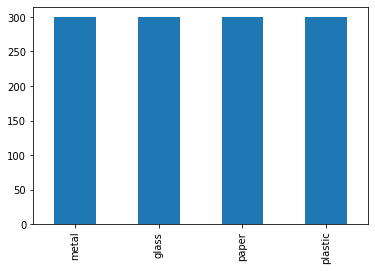

In [ ]:
df['Waste Type'].value_counts().plot.bar()
print (df['Waste Type'].value_counts())

Splitting Training and Validation Data (75% - 25%)

In [ ]:
train_set = df.sample(frac=0.75,replace=False)

valid_set = df.drop(train_set.index.values)

Training Data Frame

glass      231
metal      227
paper      227
plastic    215
Name: Waste Type, dtype: int64


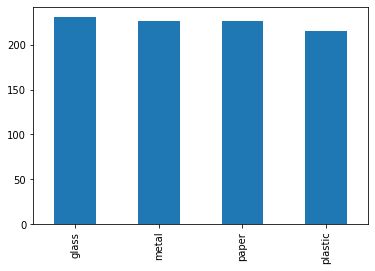

In [ ]:
train_set['Waste Type'].value_counts().plot.bar()
print (train_set['Waste Type'].value_counts())

Validation Data Frame

plastic    85
metal      73
paper      73
glass      69
Name: Waste Type, dtype: int64


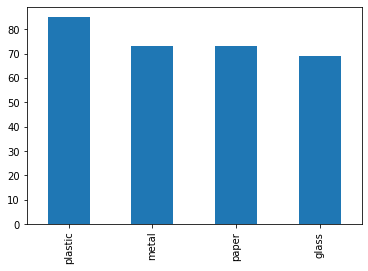

In [ ]:
valid_set['Waste Type'].value_counts().plot.bar()
print(valid_set['Waste Type'].value_counts())

Sample Image

/content/drive/MyDrive/Images/metal264.jpg


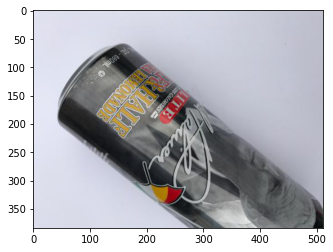

In [ ]:
sample_im = random.choice(train_set['Filename'])
image = load_img(sample_im)
plt.imshow(image)
print(sample_im)

Building CNN (Convolution Neural Network) Model

In [ ]:
model = Sequential([Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(Im_W, Im_H, Im_channels)),
                     BatchNormalization(),
                     MaxPooling2D(pool_size=(2, 2)),
                     Dropout(d_rate),
                    
                    Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(Im_W, Im_H, Im_channels)),
                     BatchNormalization(),
                     MaxPooling2D(pool_size=(2, 2)),
                     Dropout(d_rate),
                    
                    Conv2D(128, (3, 3), activation='relu', padding='same', input_shape=(Im_W, Im_H, Im_channels)),
                     BatchNormalization(),
                     MaxPooling2D(pool_size=(2, 2)),
                     Dropout(d_rate),
                    
                       Flatten(),
                    
                        Dense(1024, activation='relu'),
                        BatchNormalization(),
                        Dropout(0.5),
                        
                        Dense(512, activation='relu'),
                        BatchNormalization(),
                        Dropout(0.5),
                    
                        Dense(256, activation='relu'),
                        BatchNormalization(),
                        Dropout(0.5),
                    
                        Dense(128, activation='relu'),
                        BatchNormalization(),
                        Dropout(0.5),
                    
                        Dense(4, activation='softmax')

                ])
model.compile(
    loss='mse', 
    optimizer='adam', 
    metrics=['categorical_accuracy'],
)



model.summary()

                                 

                    
                    
                    

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 256, 192, 32)      896       
                                                                 
 batch_normalization_6 (Batc  (None, 256, 192, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 96, 32)      0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 128, 96, 32)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 96, 64)       18496     
                                                                 
 batch_normalization_7 (Batc  (None, 128, 96, 64)     

Creating an Early Stop Callback

In [ ]:
earlystop = EarlyStopping(patience=20,restore_best_weights=True)

Calculating Training and Validation Images

In [ ]:
total_train = train_set.shape[0]
total_validate = valid_set.shape[0]
print("Training: {}\nValidation: {}".format(total_train,total_validate))

Training: 900
Validation: 300


Giving Characteristics to All Training Images

In [ ]:
#train_Imdgen=Train Image Data Generator
train_Imdgen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

Generating All Training Images

In [ ]:
train_generator = train_Imdgen.flow_from_dataframe(
    train_set, 
    "", 
    x_col='Filename',
    y_col='Waste Type',
    target_size=Im_size,
    class_mode='categorical',
    batch_size=batch_size,
)

Found 900 validated image filenames belonging to 4 classes.


Generating All Validation Images

In [ ]:
#dgen=Data Generator
validation_dgen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_dgen.flow_from_dataframe(
    valid_set, 
    "", 
    x_col='Filename',
    y_col='Waste Type',
    target_size=Im_size,
    class_mode='categorical',
    batch_size=batch_size
)

Found 300 validated image filenames belonging to 4 classes.


Visualizing Sample Training Images

Found 1 validated image filenames belonging to 1 classes.


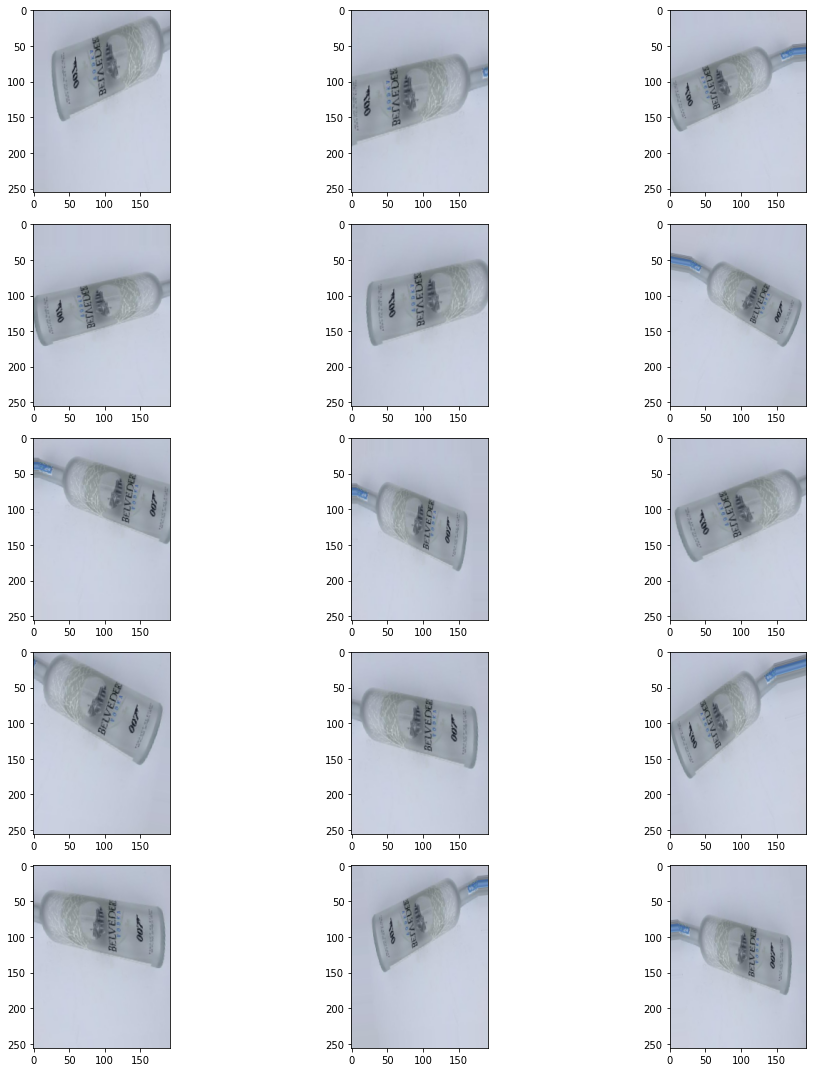

0    glass
Name: Waste Type, dtype: object

In [ ]:
example_set = train_set.sample(n=1).reset_index(drop=True)
example_generator = train_Imdgen.flow_from_dataframe(
    example_set, 
    "", 
    x_col='Filename',
    y_col='Waste Type',
    target_size=Im_size,
    class_mode='categorical'
)

plt.figure(figsize=(15, 15))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

example_set["Waste Type"]

Training CNN Model

In [ ]:
myd="/content/drive/MyDrive/images.hdf5"
history = model.fit(
    train_generator, 
    batch_size=batch_size,
    epochs=epochs,
    validation_data=validation_generator,

    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=[earlystop]
)
model.save_weights(myd)

Epoch 1/40
28/28 [==============================] - 190s 7s/step - loss: 0.2592 - categorical_accuracy: 0.2800 - val_loss: 0.2481 - val_categorical_accuracy: 0.2431
Epoch 2/40
28/28 [==============================] - 167s 6s/step - loss: 0.2453 - categorical_accuracy: 0.3122 - val_loss: 0.2943 - val_categorical_accuracy: 0.2326
Epoch 3/40
28/28 [==============================] - 168s 6s/step - loss: 0.2338 - categorical_accuracy: 0.3456 - val_loss: 0.2775 - val_categorical_accuracy: 0.2361
Epoch 4/40
28/28 [==============================] - 165s 6s/step - loss: 0.2297 - categorical_accuracy: 0.3629 - val_loss: 0.2638 - val_categorical_accuracy: 0.2465
Epoch 5/40
28/28 [==============================] - 164s 6s/step - loss: 0.2275 - categorical_accuracy: 0.3456 - val_loss: 0.2518 - val_categorical_accuracy: 0.3125
Epoch 6/40
28/28 [==============================] - 167s 6s/step - loss: 0.2177 - categorical_accuracy: 0.3767 - val_loss: 0.3061 - val_categorical_accuracy: 0.2812
Epoch 7/40

Graphical Representation of Training

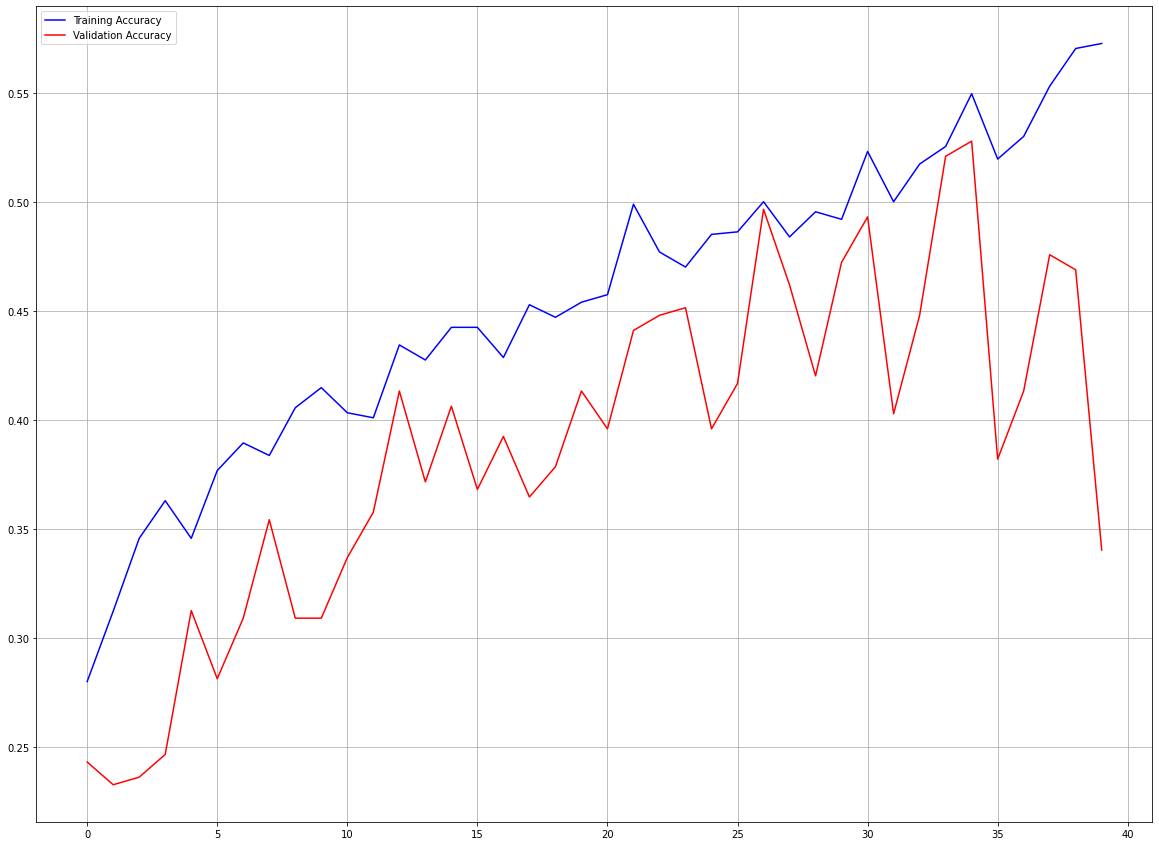

In [ ]:
plt.figure(figsize = (20, 15))
plt.plot(history.history['categorical_accuracy'], color = 'b', label = "Training Accuracy")
plt.plot(history.history['val_categorical_accuracy'], color = 'r', label = "Validation Accuracy")
plt.legend()
plt.grid()
plt.show()

Forming Generator for Testing Model

In [ ]:
test_set = df.sample(frac = 0.3)
test_samples = test_set.shape[0]

In [ ]:
test_Imdgen = ImageDataGenerator(rescale=1./255)

test_generator = test_Imdgen.flow_from_dataframe(
    test_set, 
    "", 
    x_col='Filename',
    y_col=None,
    class_mode=None,
    target_size=Im_size,
    batch_size=batch_size,
    shuffle=False
)

Found 360 validated image filenames.


Predicting

In [ ]:
prediction = model.predict_generator(test_generator, steps = np.ceil(test_samples / batch_size))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [ ]:
test_set['Predicted Waste Type'] = np.argmax(prediction, axis=-1)

label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_set['Predicted Waste Type'] = test_set['Predicted Waste Type'].replace(label_map)

Viewing Predictions

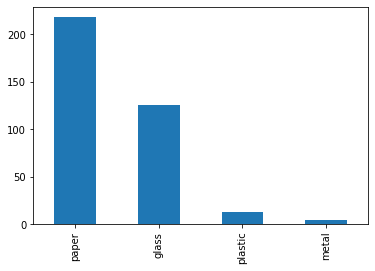

In [ ]:
test_set['Predicted Waste Type'].value_counts().plot.bar()

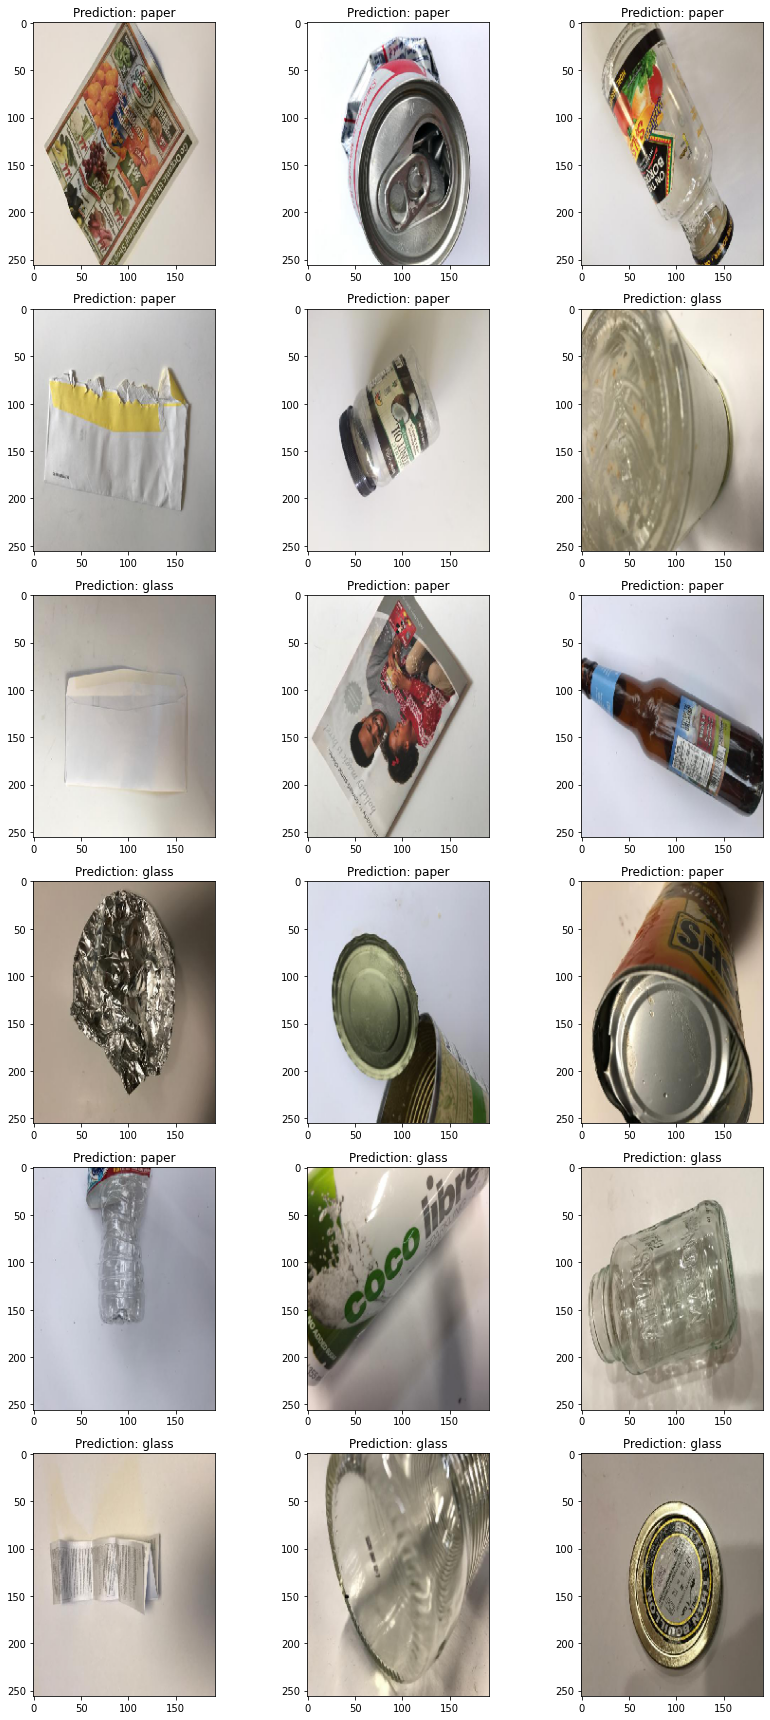

In [ ]:
test_sample = test_set.sample(n=21)
plt.figure(figsize=(12, 24))

i=1

for index, row in test_sample.iterrows():
    if i <= 18:
        file_name = row['Filename']
        waste_type = row['Predicted Waste Type']
        im = load_img(file_name, target_size=Im_size)
        plt.subplot(6, 3, i)
        plt.imshow(im)
        plt.title(f'Prediction: {waste_type}')
        i+=1
plt.tight_layout()

plt.show()

In [ ]:
test_set.head(30)

,Filename,Waste Type,Predicted Waste Type
403,/content/drive/MyDrive/Images/glass4.jpg,glass,glass
250,/content/drive/MyDrive/Images/paper291.jpg,paper,paper
211,/content/drive/MyDrive/Images/plastic224.jpg,plastic,plastic
1016,/content/drive/MyDrive/Images/glass151.jpg,glass,paper
697,/content/drive/MyDrive/Images/plastic61.jpg,plastic,paper
150,/content/drive/MyDrive/Images/plastic243.jpg,plastic,glass
698,/content/drive/MyDrive/Images/metal10.jpg,metal,paper
1160,/content/drive/MyDrive/Images/metal210.jpg,metal,paper
160,/content/drive/MyDrive/Images/plastic227.jpg,plastic,paper
520,/content/drive/MyDrive/Images/glass77.jpg,glass,paper
